In [1]:
import pandas as pd 

data = pd.read_csv('../Dataset/replicability.csv')
data

,replicability,year,title,num_ref,num_ref_3years,arxiv,neurips,iclr,icml,aaai,...,atr37,atr38,atr39,citation_count,citedIn2018,citedIn2019,citedIn2020,citedIn2021,citedIn2022,citedIn2023
0,0,2018,A Deep Reinforced Model for Abstractive Summar...,37,18,8,4,3,0,2,...,3,17,113,1195,157,223,261,168,139,48
1,0,2019,KnockoffGAN: Generating Knockoffs for Feature ...,36,8,7,0,2,1,0,...,2,52,226,41,2,11,8,11,12,1
2,0,2017,Lie-Access Neural Turing Machines,19,11,1,0,0,0,0,...,1,59,136,19,1,1,0,1,1,0
3,0,2020,Emergence of functional and structural propert...,64,11,0,1,1,0,0,...,3,76,186,20,0,1,7,7,4,5
4,0,2019,TimbreTron: A WaveNet(CycleGAN(CQT(Audio))) Pi...,42,20,14,0,1,0,0,...,1,48,182,87,0,9,20,16,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0,2017,Generative Models and Model Criticism via Opti...,30,13,1,3,9,0,1,...,0,31,100,197,9,10,11,6,7,2
711,0,2019,Disjoint Mapping Network for Cross-modal Match...,26,8,5,0,2,1,0,...,1,104,285,41,1,9,9,13,11,4
712,0,2020,Duration-of-Stay Storage Assignment under Unce...,24,1,3,0,0,0,0,...,0,59,191,2,0,0,1,1,0,0
713,0,2019,Guiding Policies with Language via Meta-Learning,45,20,1,0,1,3,4,...,3,83,214,44,1,10,10,9,15,4


In [2]:
label_counts = data.groupby(['title', 'replicability']).size().unstack(fill_value=0)
dominant_labels = label_counts.idxmax(axis=1)
data = data.merge(dominant_labels.rename('dominant_label'), left_on='title', right_index=True)
df_filtered = data[data['replicability'] == data['dominant_label']]

label_counts_0 = data[data['replicability'] == 0].groupby('title').size().rename('count_0')
label_counts_1 = data[data['replicability'] == 1].groupby('title').size().rename('count_1')

df_filtered = df_filtered.merge(label_counts_0, left_on='title', right_index=True, how='left')
df_filtered = df_filtered.merge(label_counts_1, left_on='title', right_index=True, how='left')

df_filtered = df_filtered[df_filtered['count_0'] != df_filtered['count_1']]
df_filtered = df_filtered.drop(['dominant_label', 'count_0', 'count_1'], axis=1)

In [3]:
data = df_filtered.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 0 to 714
Data columns (total 82 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   replicability   586 non-null    int64  
 1   year            586 non-null    int64  
 2   title           586 non-null    object 
 3   num_ref         586 non-null    int64  
 4   num_ref_3years  586 non-null    int64  
 5   arxiv           586 non-null    int64  
 6   neurips         586 non-null    int64  
 7   iclr            586 non-null    int64  
 8   icml            586 non-null    int64  
 9   aaai            586 non-null    int64  
 10  iccv            586 non-null    int64  
 11  cvpr            586 non-null    int64  
 12  emnlp           586 non-null    int64  
 13  acl             586 non-null    int64  
 14  naacl           586 non-null    int64  
 15  eccv            586 non-null    int64  
 16  icra            586 non-null    int64  
 17  icassp          586 non-null    int

In [4]:
data.to_csv('new-replicability.csv', index=False)

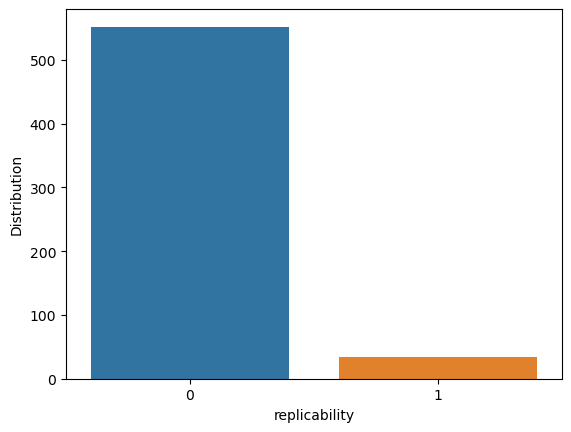

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=data['replicability'])
plt.ylabel('Distribution')
plt.show()

In [6]:
import plotly.graph_objects as go
import numpy as np

def correlation_matrix(dataframe):
    df_corr = dataframe.corr()
    fig = go.Figure()
    fig.add_trace(
        go.Heatmap(
            x = df_corr.columns,
            y = df_corr.index,
            z = np.array(df_corr),
            text=df_corr.values,
            texttemplate='%{text:.2f}'
        )
    )
    fig.show()

## Citing Sentence Predictor

In [7]:
citing_sentence = data[['atr0', 'atr1', 'atr2', 'atr3', 'atr4', 'atr5', 'atr6', 'atr7', 'atr8', 'atr9', 'atr10', 'atr11', 'atr12', 'atr13', 'atr14', 'atr15', 'atr16', 'atr17', 'atr18', 'atr19']]
y = data['replicability']

In [8]:
dataframe = citing_sentence.join([y])
correlation_matrix(dataframe)

In [9]:
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler

def find_chi(features, y, k):
    chi_square = SelectKBest(score_func=chi2, k=k)
    fit = chi_square.fit(features, y)
    
    selected_feature_indices = chi_square.get_support(indices=True)
    feature_names = features.columns
    chi2_scores = fit.scores_
    feature_score_dict = dict(zip(feature_names, chi2_scores))
    sorted_features = sorted(feature_score_dict.items(), key=lambda x: x[1], reverse=True)
    selected_feature_names = [feature[0] for feature in sorted_features[:k]]
    
    print("Selected Feature Names:", selected_feature_names)
    x_chi = chi_square.fit_transform(features, y)
    
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x_chi)
    
    x_train, x_test, y_train, y_test = train_split(x, y)
    return x_train, x_test, y_train, y_test, selected_feature_names

In [10]:
from sklearn.model_selection import train_test_split

def train_split(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)
    return x_train, x_test, y_train, y_test

In [11]:
test = pd.DataFrame(columns=['Features', 'Accuracy'])

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def model(features, y, i):
    model = XGBClassifier()
    x_train, x_test, y_train, y_test, selected_feature_names = find_chi(features, y, i)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(y_test, predictions)
    new_data = pd.DataFrame({'Features': [selected_feature_names], 'Accuracy': ["%.2f%%" % (accuracy * 100.0)]})
    global test
    test = pd.concat([test, new_data], ignore_index=True)
    return accuracy

In [13]:
for i in dict(enumerate(citing_sentence)):
    accuracy = model(citing_sentence, y, i+1)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

Selected Feature Names: ['atr13']
Accuracy: 94.07%
Selected Feature Names: ['atr13', 'atr3']
Accuracy: 94.07%
Selected Feature Names: ['atr13', 'atr3', 'atr8']
Accuracy: 94.07%
Selected Feature Names: ['atr13', 'atr3', 'atr8', 'atr14']
Accuracy: 93.22%
Selected Feature Names: ['atr13', 'atr3', 'atr8', 'atr14', 'atr0']
Accuracy: 93.22%
Selected Feature Names: ['atr13', 'atr3', 'atr8', 'atr14', 'atr0', 'atr6']
Accuracy: 94.07%
Selected Feature Names: ['atr13', 'atr3', 'atr8', 'atr14', 'atr0', 'atr6', 'atr9']
Accuracy: 92.37%
Selected Feature Names: ['atr13', 'atr3', 'atr8', 'atr14', 'atr0', 'atr6', 'atr9', 'atr4']
Accuracy: 92.37%
Selected Feature Names: ['atr13', 'atr3', 'atr8', 'atr14', 'atr0', 'atr6', 'atr9', 'atr4', 'atr10']
Accuracy: 90.68%
Selected Feature Names: ['atr13', 'atr3', 'atr8', 'atr14', 'atr0', 'atr6', 'atr9', 'atr4', 'atr10', 'atr19']
Accuracy: 92.37%
Selected Feature Names: ['atr13', 'atr3', 'atr8', 'atr14', 'atr0', 'atr6', 'atr9', 'atr4', 'atr10', 'atr19', 'atr5']
Acc

## Regular Sentences Predictor

In [14]:
regular_sentences = data[['atr20', 'atr21', 'atr22', 'atr23', 'atr24', 'atr25', 'atr26', 'atr27', 'atr28', 'atr29', 'atr30', 'atr31', 'atr32', 'atr33', 'atr34', 'atr35', 'atr36', 'atr37', 'atr38', 'atr39']]

In [15]:
dataframe = regular_sentences.join([y])
correlation_matrix(dataframe)

In [16]:
for i in dict(enumerate(regular_sentences)):
    accuracy = model(regular_sentences, y, i+1)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

Selected Feature Names: ['atr39']
Accuracy: 92.37%
Selected Feature Names: ['atr39', 'atr33']
Accuracy: 91.53%
Selected Feature Names: ['atr39', 'atr33', 'atr22']
Accuracy: 91.53%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32']
Accuracy: 92.37%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr23']
Accuracy: 92.37%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr23', 'atr25']
Accuracy: 90.68%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr23', 'atr25', 'atr38']
Accuracy: 93.22%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr23', 'atr25', 'atr38', 'atr37']
Accuracy: 93.22%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr23', 'atr25', 'atr38', 'atr37', 'atr26']
Accuracy: 92.37%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr23', 'atr25', 'atr38', 'atr37', 'atr26', 'atr30']
Accuracy: 94.07%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr23', 'atr25', 'atr38

## Reference-Based Predictor

In [17]:
reference_based = data[['num_ref', 'num_ref_3years', 'arxiv', 'neurips', 'iclr', 'icml', 'aaai', 'iccv', 'cvpr', 'emnlp', 'acl', 'naacl', 'eccv', 'icra', 'icassp', 'ijcai', 'aistats', 'sigkdd', 'neuralcom', 'ieee_tran', 'acm_tran', 'mit_press', 'nature', 'jmlr']]

In [18]:
dataframe = reference_based.join([y])
correlation_matrix(dataframe)

In [19]:
for i in dict(enumerate(reference_based)):
    accuracy = model(reference_based, y, i+1)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

Selected Feature Names: ['num_ref_3years']
Accuracy: 94.07%
Selected Feature Names: ['num_ref_3years', 'aaai']
Accuracy: 94.07%
Selected Feature Names: ['num_ref_3years', 'aaai', 'cvpr']
Accuracy: 94.07%
Selected Feature Names: ['num_ref_3years', 'aaai', 'cvpr', 'ijcai']
Accuracy: 94.07%
Selected Feature Names: ['num_ref_3years', 'aaai', 'cvpr', 'ijcai', 'aistats']
Accuracy: 94.07%
Selected Feature Names: ['num_ref_3years', 'aaai', 'cvpr', 'ijcai', 'aistats', 'eccv']
Accuracy: 94.07%
Selected Feature Names: ['num_ref_3years', 'aaai', 'cvpr', 'ijcai', 'aistats', 'eccv', 'emnlp']
Accuracy: 94.07%
Selected Feature Names: ['num_ref_3years', 'aaai', 'cvpr', 'ijcai', 'aistats', 'eccv', 'emnlp', 'icra']
Accuracy: 94.07%
Selected Feature Names: ['num_ref_3years', 'aaai', 'cvpr', 'ijcai', 'aistats', 'eccv', 'emnlp', 'icra', 'num_ref']
Accuracy: 93.22%
Selected Feature Names: ['num_ref_3years', 'aaai', 'cvpr', 'ijcai', 'aistats', 'eccv', 'emnlp', 'icra', 'num_ref', 'iccv']
Accuracy: 93.22%
Selec

## Combination Predictor

In [20]:
combination = citing_sentence.join([regular_sentences, reference_based])

In [21]:
for i in dict(enumerate(combination)):
    accuracy = model(combination, y, i+1)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

Selected Feature Names: ['atr39']
Accuracy: 92.37%
Selected Feature Names: ['atr39', 'atr33']
Accuracy: 91.53%
Selected Feature Names: ['atr39', 'atr33', 'atr22']
Accuracy: 91.53%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32']
Accuracy: 92.37%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr13']
Accuracy: 93.22%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr13', 'num_ref_3years']
Accuracy: 93.22%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr13', 'num_ref_3years', 'aaai']
Accuracy: 93.22%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr13', 'num_ref_3years', 'aaai', 'atr3']
Accuracy: 89.83%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr13', 'num_ref_3years', 'aaai', 'atr3', 'atr8']
Accuracy: 92.37%
Selected Feature Names: ['atr39', 'atr33', 'atr22', 'atr32', 'atr13', 'num_ref_3years', 'aaai', 'atr3', 'atr8', 'atr23']
Accuracy: 92.37%
Selected Feature Names: ['atr39', 'atr33', 'atr22

In [22]:
test.to_csv('replicability.xlsx', index=False)